# Loan Prediction – LightGBM

This notebook trains and evaluates a **LightGBM** model on the loan dataset (`loan_dataset_20000.csv`).

In [1]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv("../loan_dataset_20000.csv") 

X_raw = df.drop("loan_paid_back", axis=1)
y = df["loan_paid_back"]

# monthly and yearly income carry the same info monhly = yearly / 12
X_raw = X_raw.drop(columns=['monthly_income'])

X = X_raw.copy()
y = y.copy()

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

target_col = "loan_paid_back" 
X = df.drop(columns=[target_col])
y = df[target_col]

# stratify keeps the 0/1 ratio similar in train and test (important for FP/FN work)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


In [4]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

pipeline_lgbm = Pipeline([
    ('prep', preprocessor_tree),
    ('model', lgbm)
])

pipeline_lgbm.fit(X_train, y_train)

y_pred_lgbm = pipeline_lgbm.predict(X_test)
y_proba_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 12798, number of negative: 3202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799875 -> initscore=1.385513
[LightGBM] [Info] Start training from score 1.385513


C:\Users\jakim\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\jakim\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


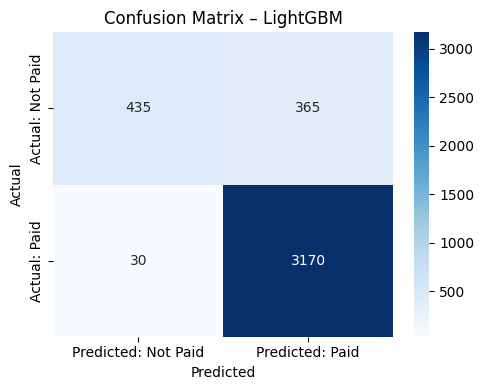

              precision    recall  f1-score   support

           0       0.94      0.54      0.69       800
           1       0.90      0.99      0.94      3200

    accuracy                           0.90      4000
   macro avg       0.92      0.77      0.81      4000
weighted avg       0.90      0.90      0.89      4000



In [5]:
cm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted: Not Paid', 'Predicted: Paid'],
    yticklabels=['Actual: Not Paid', 'Actual: Paid']
)
plt.title('Confusion Matrix – LightGBM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_lgbm))


In [7]:
# Feature names after preprocessing
prep = pipeline_lgbm.named_steps["prep"]
feature_names = prep.get_feature_names_out()

# LightGBM model (LGBMClassifier)
lgbm_model = pipeline_lgbm.named_steps["model"]

# Importances (default: split count). For gain use the next line instead.
importances = lgbm_model.feature_importances_
# importances = lgbm_model.booster_.feature_importance(importance_type="gain")

# Print in feature : importance format
for name, val in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name} : {val}")

num__credit_score : 2034
num__debt_to_income_ratio : 1998
num__interest_rate : 1220
num__current_balance : 1144
num__total_credit_limit : 1052
num__annual_income : 1042
num__installment : 995
num__age : 914
num__loan_amount : 906
num__num_of_open_accounts : 478
num__num_of_delinquencies : 386
num__delinquency_history : 281
cat__employment_status_Unemployed : 182
cat__employment_status_Student : 161
cat__employment_status_Retired : 127
cat__gender_Female : 115
cat__education_level_Bachelor's : 104
cat__loan_purpose_Debt consolidation : 104
cat__marital_status_Single : 103
cat__gender_Male : 100
cat__marital_status_Married : 97
cat__employment_status_Employed : 88
cat__employment_status_Self-employed : 87
cat__education_level_Master's : 76
cat__education_level_High School : 73
num__loan_term : 58
cat__loan_purpose_Car : 58
cat__loan_purpose_Other : 56
cat__marital_status_Divorced : 53
cat__loan_purpose_Education : 52
cat__loan_purpose_Home : 45
cat__loan_purpose_Business : 43
cat__grade_

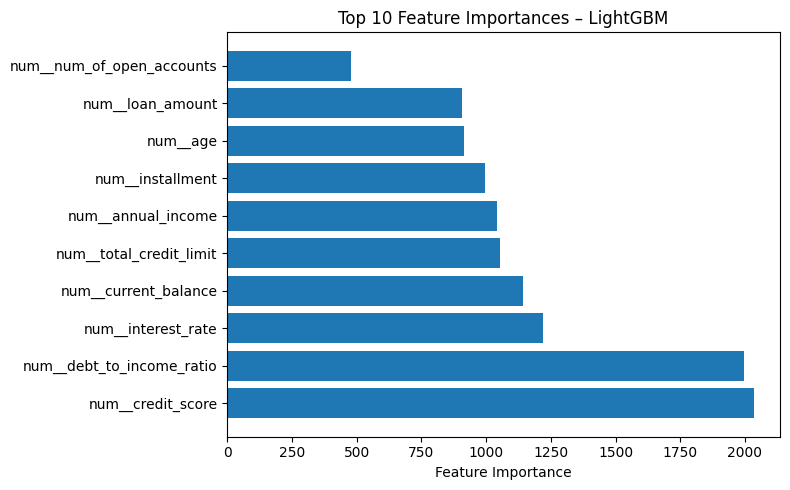

In [8]:
import matplotlib.pyplot as plt
import numpy as np

indices = np.argsort(importances)[-10:]
top_features = feature_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features, top_importances)
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances – LightGBM")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
